<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/presentation_Supervised_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Clock Drawing Image Classification with Convolutional Neural Networks
### Stacey Beck and Ian Byrne

- Split data into sets of Training (x = image arrays ; y = labels), Test (~10% image arrays), and Validation (~10% of the Training). 
- Build CNN using Pytorch for Training and Test:
  - Specify CUDA
  - 2D convolution, Normalization (for faster training), Non-linear Activation Function (ex. RELU), Max Pooling (downsampling to reduce learned parameters).
  - Define Layers 
  - Build Forward and backward pass
  - Define optimizer (due to many - deep - nodes) ex) ADAM
  - Calculate Loss (BCE)
  - Calculate Accuracy, Precision, Recall (Confusion Matrix)
  - Plot ROC and print Confusion Matrix



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
#!ls

fatal: destination path 'MADSmilestone2' already exists and is not an empty directory.
/content/MADSmilestone2


In [4]:
!pip install torchmetrics boto3

# General Libraries
import pandas as pd
import numpy as np
import ast
import logging
import os
import boto3
from botocore.exceptions import ClientError
import requests
import botocore
import tempfile


# Custom Libraries
import Loading.load_data as ld
import ImagePlayground.Images

# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchmetrics
from torch.nn.utils import spectral_norm

# To Evaluate model
from tqdm import tqdm
import torchmetrics
from torchmetrics import ConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To visualize model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread

# To split the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
from utils import open_dict
from proj_models import ResizedClocks
from utils import collate_fn
from utils import set_model
from utils import accuracy
from proj_models import ConvNet
from utils import train_val_model

In [6]:
# also import keys for aws connection
from gdrive.MyDrive.Colab_Notebooks.clocks_aws_config import clockss3
pubkey = clockss3['accessCode']
seckey = clockss3['secretCode']
client = boto3.client('s3', aws_access_key_id=pubkey, aws_secret_access_key=seckey)
#response = client.list_buckets()

In [7]:
#!rm -rf /content/MADSmilestone2

# Build CNN Model using Pytorch


### Building and Training
Architecture choices influenced from: 

https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/

https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b

https://towardsdatascience.com/how-does-sparse-convolution-work-3257a0a8fd1

In [8]:
# Define some of the hyperparameters and training variables
#epochs = 2
train_batch_size = 8
val_batch = 4
test_batch = 1
learning_rate = 1e-3
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)
weight_decay = 1e-5

# Define file extension to use for new data saves
extension_ = "mod1"

# Define which round to get data from
rnd = 1

# Define model extensions for naming file (which model do we want to train on)
model_ext = "4_fix"
m = 'First model'
#m = 'pre-trained'
#m = 'pre-trained-res'
#m = 'resnet'

In [9]:
dictionarytr = open_dict(
    '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/train_dict_nhat.txt'
)
dictionaryv = open_dict(
    '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/val_dict_nhat.txt'
)
dictionaryts = open_dict(
    '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/test_dict_nhat.txt'
)

In [10]:
train_set = ResizedClocks(rnd, dictionarytr[rnd], pubkey, seckey, normalize_=False)
val_set = ResizedClocks(rnd, dictionaryv[rnd], pubkey, seckey, normalize_=False)
test_set = ResizedClocks(rnd, dictionaryts[rnd], pubkey, seckey, normalize_=False)

In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle = True, num_workers = 6, collate_fn=collate_fn) 
validate_loader = torch.utils.data.DataLoader(val_set, batch_size = val_batch, shuffle = True, num_workers = 6, collate_fn=collate_fn) #64, 8,1

In [12]:
# For round 10, there are some corrupt data that when batched at size 1 is not taken
# care of by the collate function, but Nonechucks library skips the missing data and 
# moves on, replacing that missing data index with the next piece of data
# could probably just use this in place of collate for all the loading
if rnd == 10:
  !pip install nonechucks
  import nonechucks as nc
  test_set_safe = nc.SafeDataset(test_set)
  test_loader = torch.utils.data.DataLoader(test_set_safe, batch_size = test_batch, shuffle = False)

else:
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = test_batch, shuffle = False, collate_fn=collate_fn)

torch.FloatTensor


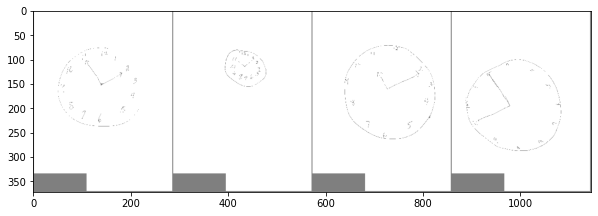

Labels:
    2              2              2              2


In [13]:
# Visualize the validation data if grayscale 
# Code taken and adapted from Pytorch tutorial
#Labels 
classes = (0, 1, 2)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    #npimg = img.numpy()
    plt.figure(figsize=(10,15))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

batch = 8
# get some random training images
dataiter = iter(validate_loader)
images, labels = dataiter.next()
#print(images.size())
print(images.type())
#images = images.unsqueeze(1)
#print(type(np.float32(labels)))
# show images
ims = torchvision.utils.make_grid(images, nrow = 4)
imshow(ims)
# print labels
print('Labels:')
print('          '.join('%5s' % classes[labels[j]] for j in range(val_batch)))

#Printing as RGB, just using basic pytorch dataloader likely converting to rbg

In [14]:
 # Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
# Get model
model = set_model(m, model_ext, device)

# Print weights
#for param in model.parameters():
  #print(str(param.data.numpy().shape)+'\n')
  #print("weights fc1: ", model.fc1.weight)

# Loss function
criterion = nn.CrossEntropyLoss(reduction="mean")

# Optimizer (can use SGD or ADAM)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)#, momentum = 0.9) #or ADAM/ momentum
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay= weight_decay) 

#scheduler = lr_scheduler.StepLR(optimizer, step_size = 4, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 4)

print(model)

accuracy_stats = {
    'train': [],
    'val': []
  }

print(accuracy_stats)

loss_stats = {
    'train': [],
    'val': []
    }
print(loss_stats)

First Model training on GPU
ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do2): Dropout(p=0.3, inplace=False)
  (fc1): Line

In [18]:
train_val_model(15, model, train_loader, device, optimizer, criterion, validate_loader)


Epoch$ : 1


  0%|          | 0/423 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  3%|▎         | 12/423 [00:09<05:18,  1.29it/s]


KeyboardInterrupt: ignored

# Visualize the Training and Validation


In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
#train_val_acc_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/acc{}.csv'.format(extension_), index = False)
#train_val_loss_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/loss{}.csv'.format(extension_), index = False)
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/acc_loss{}.png'.format(extension_))

# Evaluate the model using Test Set

In [ ]:
# Calculate performance
y_test = torch.tensor([])
test_acc = torchmetrics.Accuracy()

with torch.set_grad_enabled(False):
  model.eval()
  #model.to(float)
  for batches in tqdm(test_loader):
    x_test, y_test = batches
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(x_test)
    test_acc(y_pred.cpu(), y_test.cpu())
    total_test_acc = test_acc.compute()
  print('test acc: ', total_test_acc)
  test_acc.reset()
   

## Create Confusion Matrix

In [ ]:
all_pred = []
all_preds = torch.tensor([])
y_test = torch.tensor([])
with torch.set_grad_enabled(False):
  model.eval()
  for x_test_batch, y_test_batch in tqdm(test_loader):
    x_test_batch = x_test_batch.to(device)#.to(float).to(device)
    y_test_pred = model(x_test_batch)
    _, y_pred_ = torch.max(y_test_pred, dim = 1)
    #print(y_pred_)
    all_pred.append(y_pred_.cpu().numpy())
    all_preds = torch.cat((all_preds.cpu(), y_pred_.cpu()),dim = 0)
    y_test = torch.cat((y_test, y_test_batch), dim = 0) 

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, all_pred))#.rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='BuGn')
plt.title("Training on NHAT Labeled Data - ResNet")
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
#plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/CMTX{}.png'.format(extension_))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
#class_names = ["Possible Dementia", "Likely Dementia", "No Dementia"]
class_vals = [0,1,2]

#cr = classification_report(y_test, all_pred, class_vals, output_dict = True)
#try:
    #cr_file = open('/content/gdrive/MyDrive/Colab Notebooks/model_charts/cr{}.txt'.format(extension_), 'wt')
    #cr_file.write(str(cr))
    #cr_file.close()
  
#except:
    #print("Unable to write to file")
print(classification_report(y_test, all_pred, class_vals))


# Plot ROC curve

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [0, 1, 2]

# set plot figure size
fig, ax_ = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test1, all_pred1, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test1)
    y_test1 = lb.transform(y_test1)
    all_pred1 = lb.transform(all_pred1)

    for (idx, label_) in enumerate(target):
        fp, tp, thresholds = roc_curve(y_test1[:,idx].astype(int), 
                                         all_pred1[:,idx])
        ax_.plot(fp, tp, label = '%s (AUC:%0.2f)'  % (label_, auc(fp, tp)))

    ax_.plot(fp, fp, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test1, all_pred1, average = average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, all_pred))

ax_.legend()
ax_.set_title('ROC Curve for NHAT Labeled Data - ResNet')
ax_.set_xlabel('False Positive Rate')
ax_.set_ylabel('True Positive Rate')
#plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/roc{}.png'.format(extension_))
plt.show()

In [ ]:
# precision recall curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve


# Use label_binarize to be multi-label like settings
y = y_test.numpy()
Y = label_binarize(y, classes=[0, 1, 2])
Y_pred = label_binarize(all_pred, classes=[0, 1, 2])
n_classes = Y.shape[1]

precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                        Y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("NHAT Labeled Data - ResNet")
plt.suptitle("Precision vs. Recall Curve")
#plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/auc_pr{}.png'.format(extension_))
plt.show()

## Save the GPU CNN Model
Also includes loading on GPU

In [ ]:
# Save GPU model
model_name = 'cnn_512_662.model{}'.format(extension_)
PATH = "/content/gdrive/MyDrive/Colab Notebooks/Models/{}".format(model_name)
#torch.save(model.state_dict(), PATH)

# Visualize Predictions

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# instantiate writer
writer = SummaryWriter('/content/gdrive/MyDrive/Colab Notebooks/Images from model/im_pred1')


# Add images from current dataset
dataiter = iter(train_loader)
images, labels = dataiter.next()
ims = torchvision.utils.make_grid(images, nrow = 4)
plt.imshow(ims)
writer.add_image('4 validation images', ims)

#!tensorboard --logdir=runs

# Visualize the model
writer.add_graph(model, images)
writer.close()

In [ ]:
crtxt = '/content/gdrive/MyDrive/Colab Notebooks/model_charts/cr3_hat.txt'
cust_file = open(crtxt, "r")
#print(cust_file.readline())
contents = cust_file.read()
dict_ = ast.literal_eval(contents)
cust_file.close()
df = pd.DataFrame(dict_)
df.rename(columns = {'0': "Possible Dementia (0)", '1': "Likely Dementia (1)",
                     '2': "No Dementia (2)"}, inplace = True)
df